In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Reading the data file
data=pd.read_csv(r'C:\Users\User\Desktop/Oil.csv')
#setting index as date
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']

In [6]:
# print dimensions and view of data
print(data.shape)
print(data)


(238, 2)
                 Date  OILPRODUS
Date                            
2002-01-01 2002-01-01       5848
2002-02-01 2002-02-01       5871
2002-03-01 2002-03-01       5883
2002-04-01 2002-04-01       5859
2002-05-01 2002-05-01       5924
...               ...        ...
2021-06-01 2021-06-01      11307
2021-07-01 2021-07-01      11307
2021-08-01 2021-08-01      11141
2021-09-01 2021-09-01      10809
2021-10-01 2021-10-01      11387

[238 rows x 2 columns]


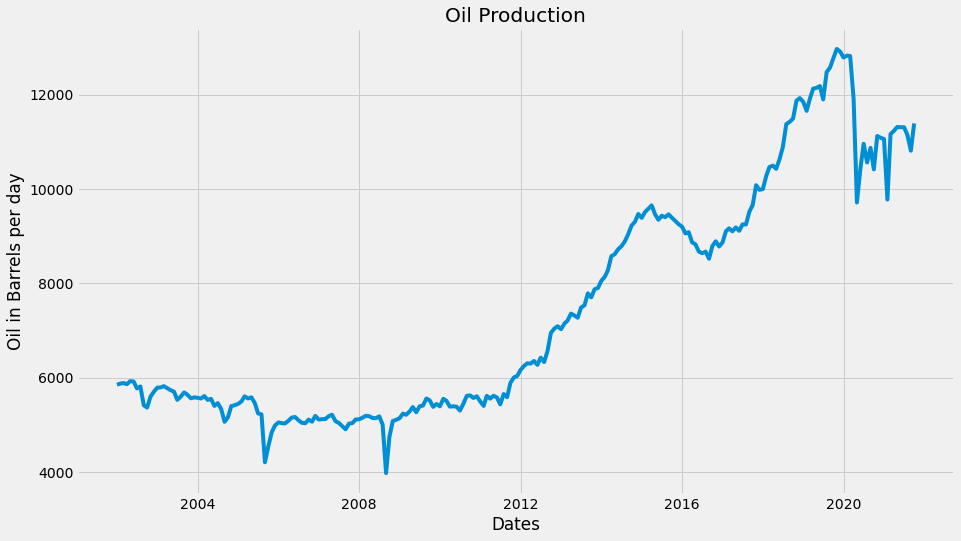

In [9]:
#plot close price
plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Oil in Barrels per day')
plt.plot(data['OILPRODUS'])
plt.title('Oil Production')
plt.show()


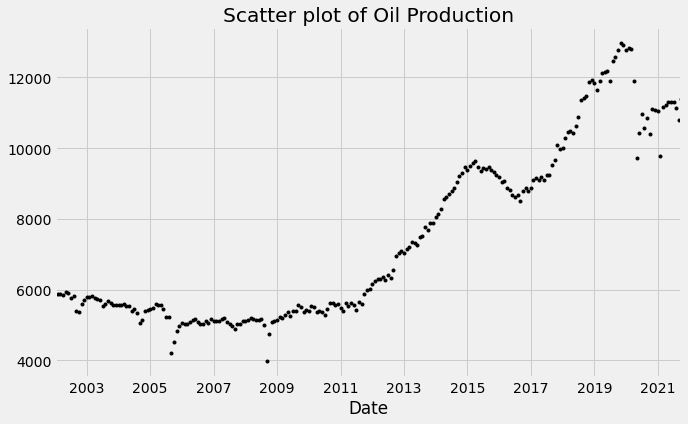

In [10]:
#Scatterplot
df_close = data['OILPRODUS']
df_close.plot(style='k.')
plt.title('Scatter plot of Oil Production')
plt.show()

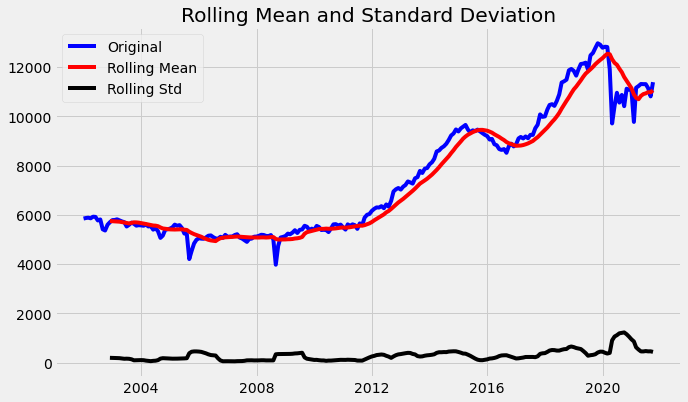

Results of dickey fuller test
Test Statistics                 -0.335416
p-value                          0.920336
No. of lags used                 9.000000
Number of observations used    228.000000
critical value (1%)             -3.459361
critical value (5%)             -2.874302
critical value (10%)            -2.573571
dtype: float64


In [12]:
#Test for staionarity as forecasting works on stationary data
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

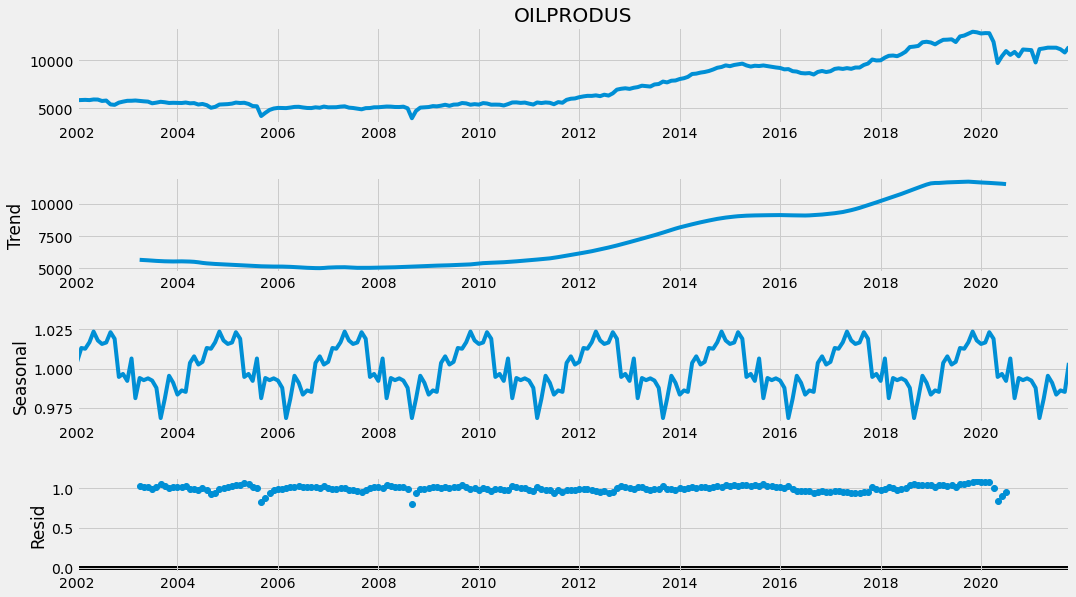

In [13]:
# Separating trend and seasonality from the data
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No handles with labels found to put in legend.


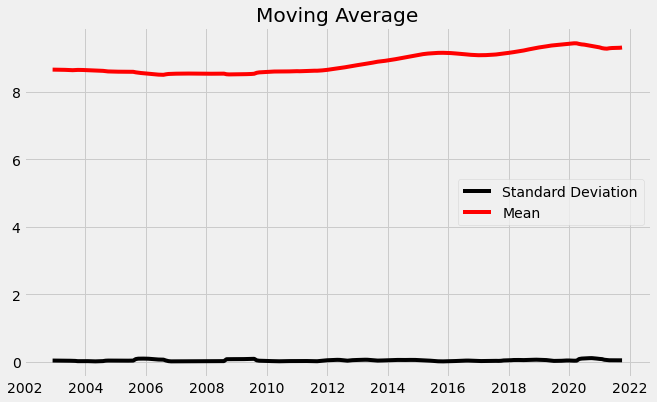

In [14]:
#  taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. 
#Then after getting the log of the series, we find the rolling average of the series.
#A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

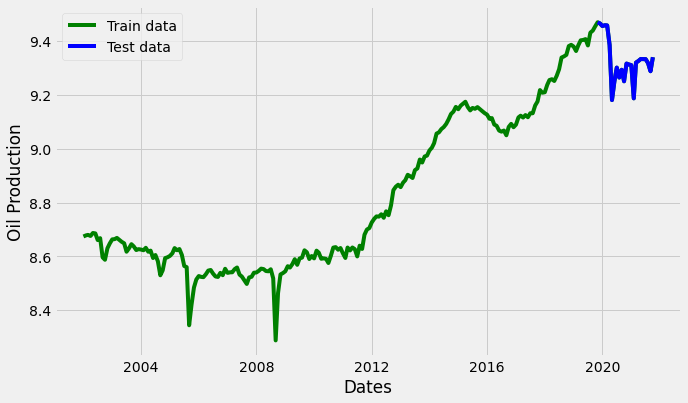

In [15]:
#we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. 
#So let us split the data into training and test set and visualize it.
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Oil Production')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [16]:
#Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-846.094, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-847.161, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-847.977, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-845.284, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-847.768, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-848.099, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-846.107, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-846.106, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-844.409, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-845.467, Time=0.13 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.902 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  211
Model:               SARIMAX(0, 1, 2)   Log Likelihood        

In [17]:
#create an ARIMA model with provided optimal parameters p, d and q.
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.OILPRODUS   No. Observations:                  210
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 428.282
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 30 Dec 2021   AIC                           -842.563
Time:                        19:06:55   BIC                           -819.133
Sample:                    05-01-2002   HQIC                          -833.091
                         - 10-01-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037      0.002      2.272      0.023       0.001       0.007
ar.L1.D.OILPRODUS    -0.4406      0.509     -0.865      0.387      -1.439       0.557
ar.L2.D.OILPRODUS     0.

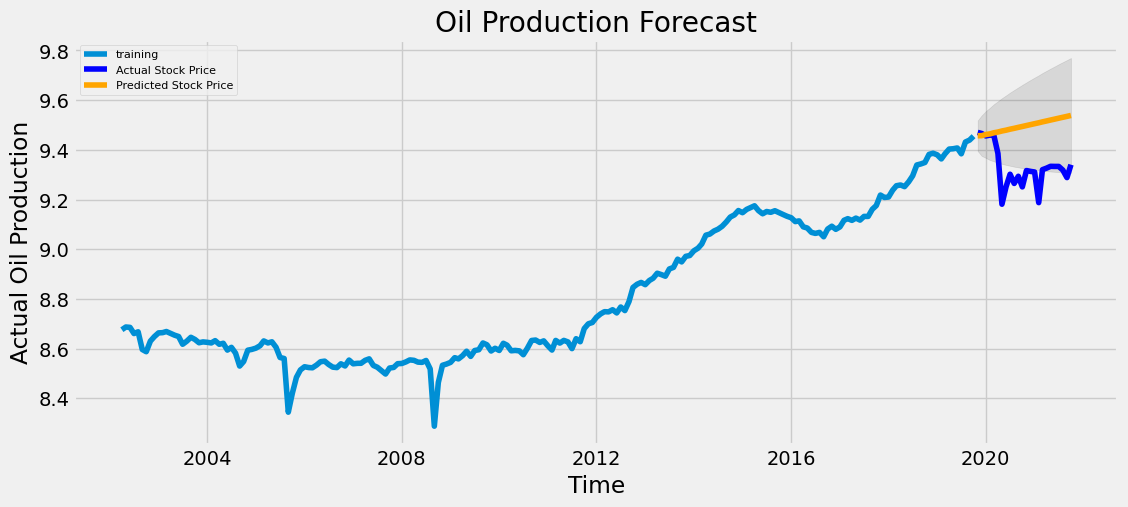

In [20]:
# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Oil Production Forecast')
plt.xlabel('Time')
plt.ylabel('Actual Oil Production')
plt.legend(loc='upper left', fontsize=8)
plt.show()